In [1]:
#defaultFolder="../input/aptos2019-blindness-detection"
defaultFolder="../input/resized-2015-2019-blindness-detection-images"

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import tensorflow as tf
#from tensorflow import keras
import tensorflow.keras.preprocessing.image as image
import IPython.display as display
import matplotlib.image as mping;
import matplotlib.pyplot as plt;
import scipy.ndimage
import imageio
import seaborn as sns
import cv2
#from tensorflow.keras.applications import resnet50,vgg16,DenseNet121
#from tensorflow.keras import callbacks
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras import layers 
from sklearn.model_selection import train_test_split
from efficientnet import *

from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications import VGG16,VGG19, DenseNet121,DenseNet169,InceptionResNetV2,ResNet50
from keras.callbacks import Callback, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam,RMSprop
from keras import layers
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from keras.models import load_model,Input,Model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import gc


#from tensorflow.keras.applications.resnet50 import preprocess_input
#from tensorflow.keras.applications.vgg19 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir(defaultFolder))

# Any results you write to the current directory are saved as output.

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

['resized train 15', 'resized test 19', 'resized test 15', 'labels', 'resized train 19']


Using TensorFlow backend.


In [3]:
print(os.listdir(defaultFolder+'/labels'))

['trainLabels15.csv', 'trainLabels19.csv', 'testLabels15.csv', 'testImages19.csv']


In [4]:
train_data_15=pd.read_csv(defaultFolder+'/labels/trainLabels15.csv')
train_data_19=pd.read_csv(defaultFolder+'/labels/trainLabels19.csv')
test_data=pd.read_csv(defaultFolder+'/labels/testImages19.csv')

In [5]:
train_data_15=train_data_15.rename(columns={"image": "id_code","level":"diagnosis"})


In [6]:
train_data_15["id_code"]=train_data_15["id_code"].apply(lambda x:defaultFolder+'/resized train 15/'+x+".jpg")
train_data_19["id_code"]=train_data_19["id_code"].apply(lambda x:defaultFolder+'/resized train 19/'+x+".jpg")
train_data_15.head()


,id_code,diagnosis
0,../input/resized-2015-2019-blindness-detection...,0
1,../input/resized-2015-2019-blindness-detection...,0
2,../input/resized-2015-2019-blindness-detection...,0
3,../input/resized-2015-2019-blindness-detection...,0
4,../input/resized-2015-2019-blindness-detection...,1


In [7]:
train_data_19.head()

,id_code,diagnosis
0,../input/resized-2015-2019-blindness-detection...,2
1,../input/resized-2015-2019-blindness-detection...,4
2,../input/resized-2015-2019-blindness-detection...,1
3,../input/resized-2015-2019-blindness-detection...,0
4,../input/resized-2015-2019-blindness-detection...,0


In [8]:
train_data_15.groupby('diagnosis').count()

,id_code
diagnosis,
0,25810
1,2443
2,5292
3,873
4,708


In [9]:
tran15=train_data_15.groupby('diagnosis',as_index=False).apply(pd.DataFrame.sample, frac=0.7)
tran15.groupby('diagnosis').count()

,id_code
diagnosis,
0,18067
1,1710
2,3704
3,611
4,496


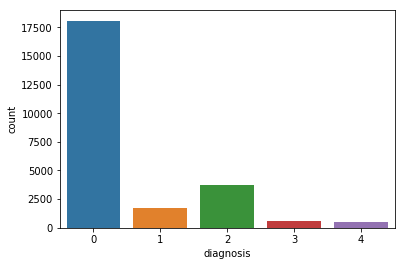

In [10]:
sns.countplot(data=tran15,x='diagnosis')

In [11]:
train_data=[]
train_data=pd.concat([train_data_19,tran15],sort=False,axis=0)
train_data.head()

,id_code,diagnosis
0,../input/resized-2015-2019-blindness-detection...,2
1,../input/resized-2015-2019-blindness-detection...,4
2,../input/resized-2015-2019-blindness-detection...,1
3,../input/resized-2015-2019-blindness-detection...,0
4,../input/resized-2015-2019-blindness-detection...,0


In [12]:
train_data.shape

(28250, 2)

In [13]:
IMAGE_SIZE=(256, 256)
imagesize=256
SEED=442
train_data.dtypes   

id_code      object
diagnosis     int64
dtype: object

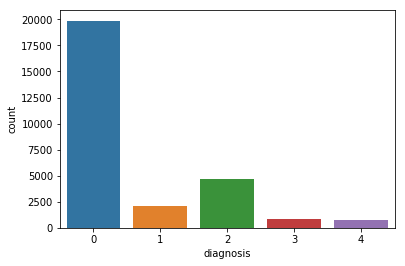

In [14]:
sns.countplot(data=train_data,x='diagnosis')

In [15]:
train_data['diagnosis'] = train_data['diagnosis'].astype(str)
y_train=train_data['diagnosis']

In [16]:
test_data["id_code"]=test_data["id_code"].apply(lambda x:defaultFolder+'/resized test 19/'+x+".jpg")
test_data.head()

,id_code
0,../input/resized-2015-2019-blindness-detection...
1,../input/resized-2015-2019-blindness-detection...
2,../input/resized-2015-2019-blindness-detection...
3,../input/resized-2015-2019-blindness-detection...
4,../input/resized-2015-2019-blindness-detection...


In [17]:
train_data.dtypes

id_code      object
diagnosis    object
dtype: object

In [18]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [19]:
def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    #img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

(256, 256, 3)

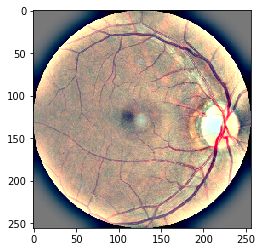

In [20]:
defaultTrainPath=defaultFolder+'/train_images/'

def preprocess_Color_image(image_path,sigmaX=40):
    """
    Create circular crop around image centre    
    """    
    
    #print(image_path)
    image_arr = cv2.imread(image_path)
    img = crop_image_from_gray(image_arr)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,120)  
    img = cv2.resize(img, (IMAGE_SIZE))
    #im = cv2.resize(im, (IMAGE_SIZE))
    return img

img=preprocess_Color_image('../input/resized-2015-2019-blindness-detection-images/resized train 15/40_left.jpg')
plt.imshow(img)
img.shape

../input/resized-2015-2019-blindness-detection-images/resized train 19/000c1434d8d7.jpg
../input/resized-2015-2019-blindness-detection-images/resized train 19/001639a390f0.jpg
../input/resized-2015-2019-blindness-detection-images/resized train 19/0024cdab0c1e.jpg
../input/resized-2015-2019-blindness-detection-images/resized train 19/002c21358ce6.jpg


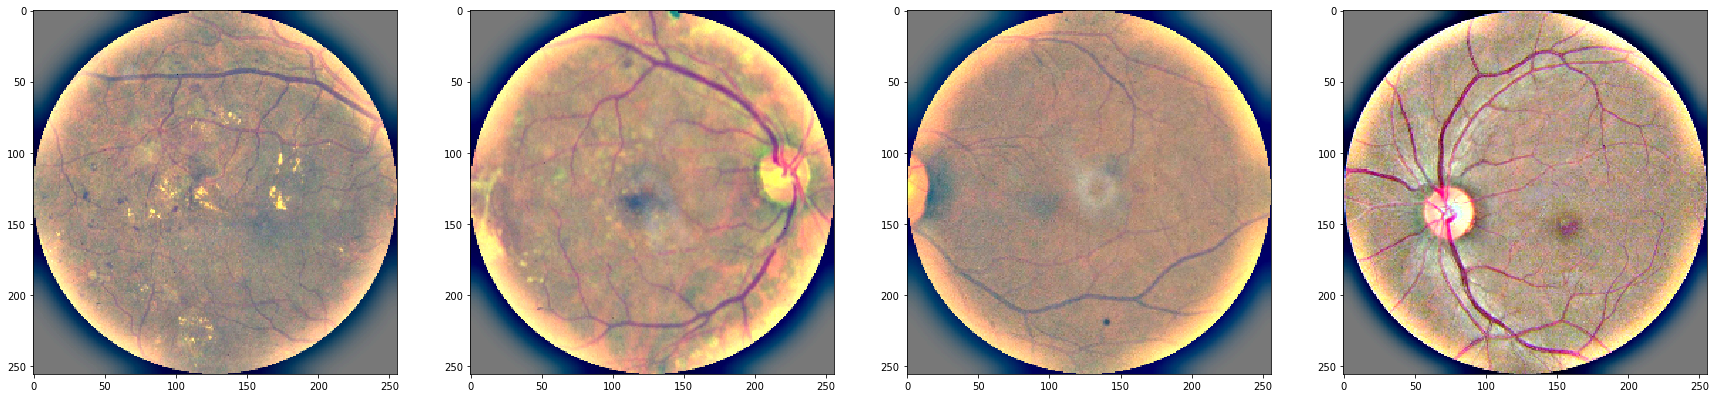

In [21]:
fig, axarr = plt.subplots(1, 4, figsize=(30, 8))
count=0;
for i,row in train_data[:4].iterrows():
  if (count<=4):
    print(row['id_code'])
    img1=imageio.imread(row['id_code'])
    axarr[count].imshow(preprocess_Color_image(row['id_code']),cmap='gray')

    height, width, channels = img1.shape
    #axarr[count].set_title("\nheight "+str(height) +"\nwidth "+str(width) +"\nchannels"+str(channels)+"\n"+str(row['id_code'])+"\n"+str(row['diagnosis']),
   #                                                                                                                  fontsize=60)
    count=count+1;

../input/resized-2015-2019-blindness-detection-images/resized train 19/001639a390f0.jpg
../input/resized-2015-2019-blindness-detection-images/resized train 19/0083ee8054ee.jpg
../input/resized-2015-2019-blindness-detection-images/resized train 19/0243404e8a00.jpg
../input/resized-2015-2019-blindness-detection-images/resized train 19/02685f13cefd.jpg


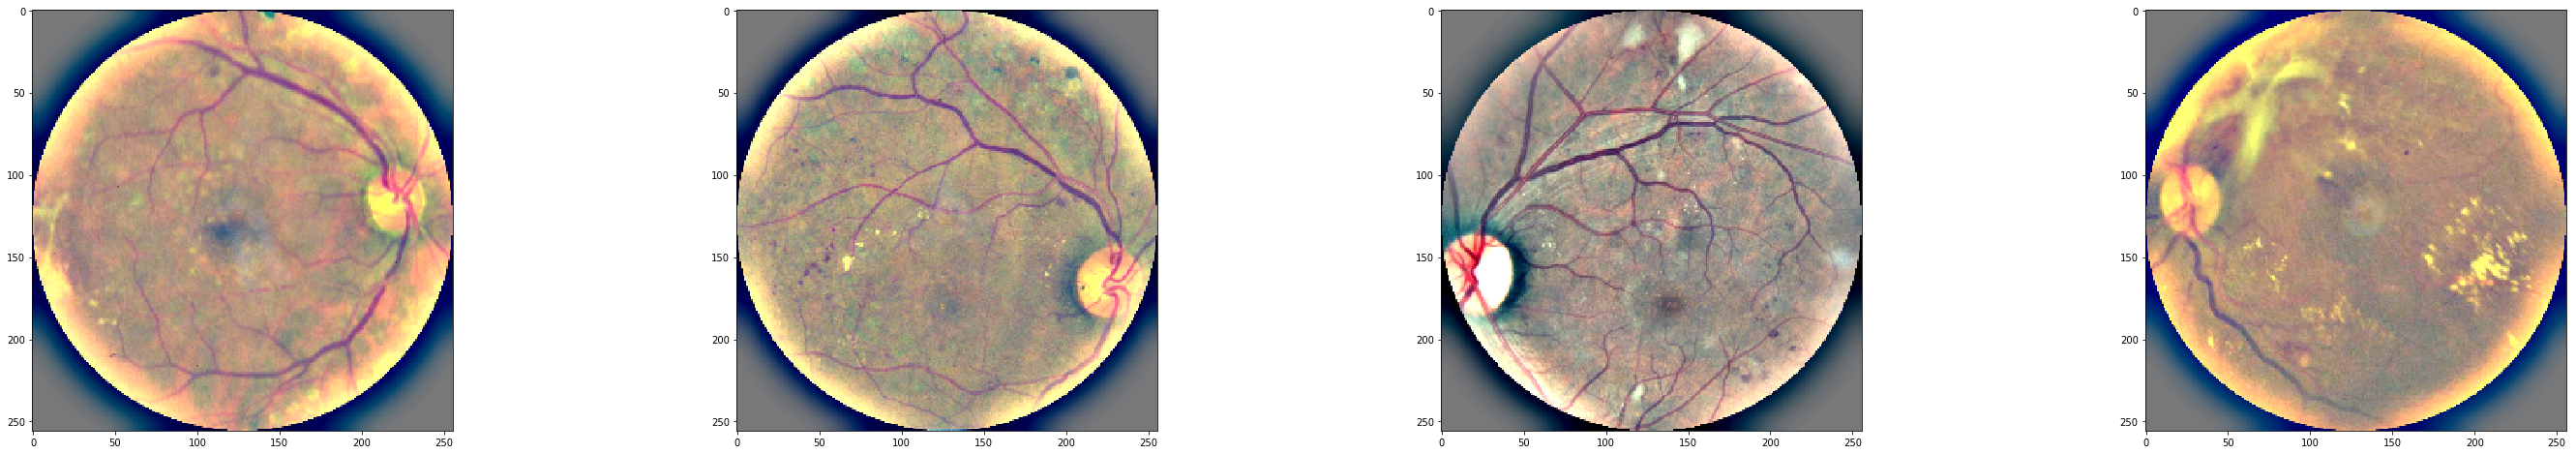

In [22]:
fig, axarr = plt.subplots(1, 4, figsize=(50, 8))
count=0;
for i,row in train_data[:200].iterrows():
  if ((count<=3) & (row['diagnosis']=="4")):
        #print(defaultTrainPath+row['id_code']+".png")
        img1=imageio.imread(row['id_code'])
        axarr[count].imshow(preprocess_Color_image(row['id_code']),cmap='gray')
        #height, width, channels = img1.shape                                                                                                             fontsize=60)
        print(row['id_code'])
        count=count+1;

In [23]:
def preprocess_Color_imageArr(image_arr,sigmaX=40):
    """
    Create circular crop around image centre    
    """    
    #image_arr = cv2.imread(image_path)
    img = crop_image_from_gray(image_arr)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,120)  
    img = cv2.resize(img, (IMAGE_SIZE))
    return img

In [24]:
#X_train, X_test = train_test_split(train_data, test_size=0.20, random_state=SEED)
datagen=ImageDataGenerator(rescale=1./255,
                           rotation_range=90,
                           horizontal_flip=True, 
                           vertical_flip=True,
                           zoom_range=1.9,
                           #shear_range=0.2,
                           #width_shift_range=[-1.0, +1.0],
                           #height_shift_range=[-1.0, +1.0],
                           preprocessing_function=preprocess_Color_imageArr)

train_generator=datagen.flow_from_dataframe(train_data, x_col='id_code', y_col="diagnosis", target_size=IMAGE_SIZE, class_mode='raw',color_mode='rgb', batch_size=16, shuffle=True, seed=SEED)



#valid_datagen=ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_Color_imageArr)

#valid_generator=valid_datagen.flow_from_dataframe(X_test, x_col='id_code', y_col="diagnosis", target_size=IMAGE_SIZE, class_mode='raw',color_mode='rgb', batch_size=16, shuffle=True, seed=SEED)

Found 28250 validated image filenames.


In [25]:
print(os.listdir('../input/'))

['aptosweightslb78', 'efficientnet-keras-weights-b0b5', 'b5-cv-of-mixed-aptos-2019-blindness-detection', 'resized-2015-2019-blindness-detection-images', 'aptos2019-blindness-detection', 'mixed-aptos-2019-blindness-detection-efficientnet']


In [26]:
Image_Shape=(imagesize,imagesize,3)
#base_model=EfficientNetB5(input_shape=(Image_Shape),
#                                      include_top=False,
#                                   # weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5')
 #                                   #pooling='avg',
#                                       weights=None)
#base_model.summary()
#base_model.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')
#
#model=load_model('../input/aptosweightslb78/aptos_efficientnet-b5_model.best.h5')
#model.load_weights('../input/aptosweightslb78/aptos_efficientnet-b5_weights.best.h5')
model=load_model('../input/b5-cv-of-mixed-aptos-2019-blindness-detection/aptos_efficientnet-cv-b5_model.best.h5')
model.load_weights('../input/b5-cv-of-mixed-aptos-2019-blindness-detection/aptos_efficientnet-cv-b5_weights.best.h5')
#model.summary()
#base_model=ResNet50(input_shape=(Image_Shape),
#                                    include_top=False,
#                                   # weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5')
#                                    #pooling='avg',
                                    #weights='../input/keras-pretrained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5')
                                     #weights=None)
#                                     weights='../input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')


#base_model.summary()

In [27]:
#base_model.get_layer(index=-3).output
#model.summary()

In [28]:
#print("Number of layers in the base model: ", len(base_model.layers))

In [29]:
model.trainable = True
# Fine tune from this layer onwards
#fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
#for layer in base_model.layers[:fine_tune_at]:
#    layer.trainable =  True
#bottleneck_input  = base_model.get_layer(index=0).input
#bottleneck_output = base_model.get_layer(index=-1).output
#bottleneck_model  = Model(inputs=bottleneck_input,outputs=bottleneck_output)

#def build_model():
#    model = Sequential()
#    model.add(bottleneck_model)
#    model.add(layers.Dropout(0.25))
#    model.add(layers.Dense(256))
#    model.add(layers.LeakyReLU())
#    model.add(layers.GlobalAveragePooling2D())
#    model.add(layers.Dropout(0.25))
#    model.add(layers.Dense(1, activation='linear'))

 #   return model

#model = build_model()
model.compile(
        loss='mean_squared_error',
        optimizer=Adam(lr=0.0001),
        metrics=['mse','accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 8, 8, 2048)        28513520  
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 2048)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 8, 8, 64)          131136    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total para

In [30]:
es = EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=5, min_lr=0.00001,verbose=1,cooldown=1)
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=1e-2, patience=3,verbose=1)

mcp = ModelCheckpoint(
        filepath='aptos_efficientnet-cv-b5_weights.best.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='loss',
        mode='min',
        verbose=1)

In [31]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([0.28431965, 2.71634615, 1.20136083, 7.02736318, 7.14285714])

In [32]:
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=SEED)
X=train_data.id_code
Y=train_data.diagnosis

In [33]:
def generateInputImageArr(data):
    N = data.shape[0]
    imageArr = np.empty((N, imagesize, imagesize, 3), dtype=np.uint8)
    for i, image_id in enumerate(tqdm_notebook(data)):
        img=cv2.imread(f'{image_id}')
        imageArr[i, :, :, :]  = cv2.resize(img, (IMAGE_SIZE))
    return imageArr

In [34]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_VALID,STEP_SIZE_TRAIN,train_generator.batch_size

In [35]:
%%time
#STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
#print(" Train size {} , Test Size {}",STEP_SIZE_TRAIN,STEP_SIZE_VALID)
hist=model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    #validation_data=valid_generator,
                    #validation_steps=STEP_SIZE_VALID,
                    epochs=15,
                    class_weight=class_weights,
                    use_multiprocessing='True',
                    callbacks=[es,reduce_lr,mcp]
)

Epoch 1/15
1765/1765 [==============================] - 1623s 920ms/step - loss: 0.5429 - mean_squared_error: 0.5429 - acc: 0.6750

Epoch 00001: loss improved from inf to 0.54287, saving model to aptos_efficientnet-cv-b5_weights.best.h5
Epoch 2/15
1765/1765 [==============================] - 1569s 889ms/step - loss: 0.5440 - mean_squared_error: 0.5440 - acc: 0.6742

Epoch 00002: loss did not improve from 0.54287
Epoch 3/15
1765/1765 [==============================] - 1565s 887ms/step - loss: 0.5427 - mean_squared_error: 0.5427 - acc: 0.6784

Epoch 00003: loss improved from 0.54287 to 0.54270, saving model to aptos_efficientnet-cv-b5_weights.best.h5
Epoch 4/15
1765/1765 [==============================] - 1566s 887ms/step - loss: 0.5356 - mean_squared_error: 0.5356 - acc: 0.6743

Epoch 00004: loss improved from 0.54270 to 0.53561, saving model to aptos_efficientnet-cv-b5_weights.best.h5
Epoch 5/15
1765/1765 [==============================] - 1557s 882ms/step - loss: 0.5411 - mean_squared

In [36]:
model.save('aptos_efficientnet-cv-b5_model.best.h5')

In [37]:
%%time
test_datagen=ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_Color_imageArr)
test_generator=test_datagen.flow_from_dataframe(  
        dataframe=test_data,
        x_col="id_code",
        target_size = IMAGE_SIZE,
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )


Found 1928 validated image filenames.
CPU times: user 36 ms, sys: 48 ms, total: 84 ms
Wall time: 760 ms


In [38]:
%%time
y_test=model.predict_generator(test_generator, steps = len(test_generator.filenames))

CPU times: user 2min 7s, sys: 13 s, total: 2min 20s
Wall time: 1min 25s


In [39]:
test_data.id_code[0]

'../input/resized-2015-2019-blindness-detection-images/resized test 19/0005cfc8afb6.jpg'

In [40]:

coef = [0.5, 1.5, 2.5, 3.5]

for i, pred in enumerate(y_test):
    if pred < coef[0]:
        y_test[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        y_test[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        y_test[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        y_test[i] = 3
    else:
        y_test[i] = 4


In [41]:
y_test

array([[2.],
       [3.],
       [3.],
       ...,
       [3.],
       [2.],
       [2.]], dtype=float32)

In [42]:
test_data=pd.read_csv(defaultFolder+'/labels/testImages19.csv')
test_data['diagnosis'] = y_test.astype(int)
#test_data['id_code'] = test_data['id_code'].map(lambda x: str(x)[:-4])
test_data.to_csv("submission.csv",index=False)
test_data.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,2


In [43]:
loss = hist.history['loss']
val_loss= hist.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
'plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation loss')


SyntaxError: invalid syntax (<ipython-input-43-01ff6e83a4b7>, line 8)

In [44]:
mean_squared_error = hist.history['mean_squared_error']
val_mean_squared_error = hist.history['val_mean_squared_error']

plt.subplot(2, 1, 2)
plt.plot(mean_squared_error, label='Training mean squared error')
plt.plot(val_mean_squared_error, label='Validation mean squared error')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation mean squared error')
plt.xlabel('epoch')
plt.show()

KeyError: 'val_mean_squared_error'

In [45]:
accuracy = hist.history['acc']
val_accuracy = hist.history['val_acc']

plt.subplot(2, 1, 2)
plt.plot(accuracy, label='Traning Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.show()

KeyError: 'val_acc'